# Image Classification
This assignment is a simplified version of HW3 at https://speech.ee.ntu.edu.tw/~hylee/ml/2022-spring.php

Their slide also provide some information, if you don't know how to upload result to kaggle or don't understand the dataset, please refer to their [slide](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2022-course-data/Machine%20Learning%20HW3%20-%20Image%20Classification.pdf) or [video](https://www.youtube.com/watch?v=GXLwjQ_O50g).

Also, if you're familir with pytorch, it's OK to use their sample code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

In [2]:
print(tf.__version__)

2.9.1


# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.



!!!Notes: After downloading the data into colab, I downloaded it to my computer to run locally.!!!

## **Datasets**


In [3]:
img_size = 299
batch_size = 16

In [4]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    'tv',
    labels='inferred',
    label_mode='categorical', #one-hot
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=6,
    validation_split=0.25,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
)
valid_set = tf.keras.preprocessing.image_dataset_from_directory(
    'tv',
    labels='inferred',
    label_mode='categorical', #one-hot
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=6,
    validation_split=0.25,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
)
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)

Found 13296 files belonging to 11 classes.
Using 9972 files for training.
Found 13296 files belonging to 11 classes.
Using 3324 files for validation.
Found 3347 files belonging to 1 classes.


In [ ]:
#label_list = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
#print(label_list)

## Image Augmentation

In [5]:
def flip(x):
    x = tf.image.random_flip_left_right(x)
    return x

def color(x):
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.4) 
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def rotate(x):
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

def zoom(x, scale_min=0.6, scale_max=1.4):
    _, h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)
    sh = h*scale
    sw = w*scale
    x = tf.image.resize(x, (sh, sw))
    x = tf.image.resize_with_crop_or_pad(x, h, w)
    return x

def aug_fn(x):
    x = flip(x)
    x = tf.cond(tf.random.uniform([], 0, 1)>0.5, lambda: color(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0, 1)>0.75, lambda: rotate(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0, 1)>0.5, lambda: zoom(x), lambda: x)
    return x

def parse_fn(x, y):
    x = tf.cast(x, tf.float32)/255.
    return (x, y)

## Mixup and cutmix

In [6]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mixup(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

@tf.function
def get_box(lambda_value):
    cut_ratio = tf.math.sqrt(1.0-lambda_value)
    cut_w = img_size * cut_ratio # rw
    cut_w = tf.cast(cut_w, tf.int32)
    cut_h = img_size * cut_ratio # rh
    cut_h = tf.cast(cut_h, tf.int32)
    cut_x = tf.random.uniform((1,), minval=0, maxval=img_size, dtype=tf.int32) # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=img_size, dtype=tf.int32) # ry
    boundaryx1 = tf.clip_by_value(cut_x[0]-cut_w//2, 0, img_size)
    boundaryy1 = tf.clip_by_value(cut_y[0]-cut_h//2, 0, img_size)
    boundaryx2 = tf.clip_by_value(cut_x[0]+cut_w//2, 0, img_size)
    boundaryy2 = tf.clip_by_value(cut_y[0]+cut_h//2, 0, img_size)
    target_h = boundaryy2-boundaryy1
    if target_h == 0:
        target_h += 1
    target_w = boundaryx2-boundaryx1
    if target_w == 0:
        target_w += 1
    return boundaryx1, boundaryy1, target_h, target_w

@tf.function
def cutmix(train_set_one, train_set_two):
    image1, label1 = train_set_one
    image2, label2 = train_set_two

    #generate lamdba_value
    alpha = [0.25]
    beta = [0.25]
    lambda_value = sample_beta_distribution(1, alpha, beta)
    lambda_value = lambda_value[0][0]
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    crop2 = tf.image.crop_to_bounding_box(image2, boundaryy1, boundaryx1, target_h, target_w)
    image2 = tf.image.pad_to_bounding_box(crop2, boundaryy1, boundaryx1, img_size, img_size)
    crop1 = tf.image.crop_to_bounding_box(image1, boundaryy1, boundaryx1, target_h, target_w)
    img1 = tf.image.pad_to_bounding_box(crop1, boundaryy1, boundaryx1, img_size, img_size)
    image1 = image1-img1
    image = image1+image2
    
    lambda_value = 1-(target_w*target_h)/(img_size*img_size)
    lambda_value = tf.cast(lambda_value, tf.float32)
    label = lambda_value*label1+(1-lambda_value)*label2

    return image, label


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

#Separate into two datasets for mixing
#train_set = train_set.map(lambda x, y: parse_fn(aug_fn(x), y), num_parallel_calls=AUTOTUNE)
#train_set = train_set.prefetch(buffer_size=AUTOTUNE)
train_set_one = train_set.map(lambda x, y: parse_fn(aug_fn(x), y), num_parallel_calls=AUTOTUNE)
train_set_two = train_set.map(lambda x, y: parse_fn(aug_fn(x), y), num_parallel_calls=AUTOTUNE)
train_set = tf.data.Dataset.zip((train_set_one, train_set_two))
train_set = train_set.shuffle(1024).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

valid_set = valid_set.map(lambda x, y: parse_fn(x, y), num_parallel_calls=AUTOTUNE)
valid_set = valid_set.prefetch(buffer_size=AUTOTUNE)

test_set = test_set.map(lambda x: tf.cast(x, tf.float32)/255., num_parallel_calls=AUTOTUNE)
test_set = test_set.prefetch(buffer_size=AUTOTUNE)

## Show pre-processed images

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(9):
    for images, labels in train_set.take(1):
        ax = plt.subplot(3, 3, i + 1)
        #if i == 0: print(images[0])
        #print(labels[0])
        img = images[0]*255
        img = img.numpy().astype("uint8")
        plt.imshow(img)
        plt.title(np.argmax(labels[0].numpy()))
        plt.axis("off")

# Q1. Residual Block Implementation

You need to implement following three type of residual-based convolution blocks:
![](https://i.imgur.com/4IlUSFN.jpg)

* Conv1 means convolution layer with kernel size 1x1
* Global avg refers to global average over spatial domain
* You can try to use any number of kernels in the above three blocks.
* You can add any normalization layer or activation function to the above three blocks.

If you don't know how to choose the number of kernels or normalization / activation function, you can consider follow the [ResNet](https://arxiv.org/abs/1512.03385) design:

![](https://i.imgur.com/z2bPAOM.png)

# Q2. Build your neural networks
You need to build your network based on the above three type of convolution blocks, and try to get best performance.
* It's allow to use additional convolution layers.

# Q3. Use data augmentation technique

# Q4. Accuracy on test set and report

Submission: [Kaggle](https://www.kaggle.com/competitions/ml2022spring-hw3b/data)

If you need submission tutorials, please refer to [slide](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2022-course-data/Machine%20Learning%20HW3%20-%20Image%20Classification.pdf)

* Please write your thoughts and problems you encountered in the report.

Good luck!

# Blocks
Run the cells which will be used in your model.

## Block_1

In [ ]:
def block_1(x, filters, strides=1, initializer='he_normal', conv_shortcut=False):
    #Stage2~5第一個block的shortcut有接1x1 conv2d壓縮
    if conv_shortcut:
        shortcut = layers.Conv2D(filters*4, 1, strides=strides, kernel_initializer=initializer)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x
    x = layers.Conv2D(filters, 1, strides=strides, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def block_1_v2(x, filters, strides=1, initializer='he_normal', conv_shortcut=False):
    #pre-batch/activation
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    if conv_shortcut:
        shortcut = layers.Conv2D(filters*4, 1, strides=strides, kernel_initializer=initializer)(x)
    elif strides > 1:
        shortcut = layers.MaxPooling2D(1, strides=strides)(x)
    else: shortcut = x

    x = layers.Conv2D(filters, 1, strides=strides, use_bias=False, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(x)
    x = layers.Add()([shortcut, x])
    return x

In [ ]:
def block_1_d(x, filters, strides=1, initializer='he_normal', conv_shortcut=False):
    #將原先shortcut的1x1壓縮交給avg pooling
    if conv_shortcut:
        if strides > 1:
            shortcut = layers.AveragePooling2D(strides=strides, padding='same')(x)
            shortcut = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(shortcut)
        else:
            shortcut = layers.Conv2D(filters*4, 1, strides=strides, kernel_initializer=initializer)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x
    #將原先1x1壓縮交給3x3
    x = layers.Conv2D(filters, 1, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, strides=strides, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

## Block_2

In [ ]:
def block_2(x, filters, c=32, strides=1, initializer='he_normal', conv_shortcut=False):
    if conv_shortcut:
        shortcut = layers.Conv2D(filters*2, 1, strides=strides, kernel_initializer=initializer)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x
    
    #resnext這裡filter數為filter/2，這裡為了降低參數/4
    x = layers.Conv2D(filters/4, 1, strides=strides, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    path_list = []
    for _ in range(c):
        path = layers.Conv2D(filters/c, 3, padding='same', kernel_initializer=initializer)(x)
        path_list.append(path)
    x = layers.Concatenate()(path_list)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters*2, 1, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def block_2_d(x, filters, c=32, strides=1, initializer='he_normal', se=False, conv_shortcut=False):
    #將原先shortcut的1x1壓縮交給avg pooling
    if conv_shortcut:
        if strides > 1:
            shortcut = layers.AveragePooling2D(strides=strides, padding='same')(x)
            shortcut = layers.Conv2D(filters*2, 1, kernel_initializer=initializer)(shortcut)
        else:
            shortcut = layers.Conv2D(filters*2, 1, strides=strides, kernel_initializer=initializer)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x
    
    #downsampling交給後面3x3的conv layer與avg pooling
    x = layers.Conv2D(filters/4, 1, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    path_list = []
    for _ in range(c):
        #strides=strides
        path = layers.Conv2D(filters/c, 3, strides=strides, padding='same', kernel_initializer=initializer)(x)
        path_list.append(path)
    x = layers.Concatenate()(path_list)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters*2, 1, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    if se:
        path_se = block_se(x, filters*2)
        x = layers.Multiply()([path_se, x])
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

## Block_3

In [ ]:
def block_3(x, filters, strides=1, initializer='he_normal', conv_shortcut=False):
    if conv_shortcut:
        shortcut = layers.Conv2D(filters*4, 1, strides=strides, kernel_initializer=initializer)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=strides, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    path1 = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(x)
    concat_input1 = layers.BatchNormalization()(path1)
    
    path2 = layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer)(x)
    path2 = layers.BatchNormalization()(path2)
    path2 = layers.Activation('relu')(path2)
    
    path3 = layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer)(x)
    path3 = layers.BatchNormalization()(path3)
    path3 = layers.Activation('sigmoid')(path3)
    path3 = layers.GlobalAveragePooling2D()(path3)
    
    mul_output = layers.Multiply()([path2, path3])
    
    concat_input2 = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(mul_output)
    concat_input2 = layers.BatchNormalization()(concat_input2)
    concat_output = layers.Concatenate()([concat_input1, concat_input2])
    concat_output = layers.Activation('relu')(concat_output)
    concat_output = layers.Conv2D(filters*4, 3, padding='same', kernel_initializer=initializer)(concat_output)
    concat_output = layers.BatchNormalization()(concat_output)
    
    add_output = layers.Add()([concat_input2, concat_output, shortcut])
    add_output = layers.Activation('relu')(add_output)
    
    return add_output

In [ ]:
def block_3_d(x, filters, r=8, strides=1, initializer='he_normal', conv_shortcut=False):
    if conv_shortcut:
        if strides > 1:
            shortcut = layers.AveragePooling2D(strides=strides, padding='same')(x)
            shortcut = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(shortcut)
        else:
            shortcut = layers.Conv2D(filters*4, 1, strides=strides, kernel_initializer=initializer)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x
    
    #downsampling交給後面3x3的conv layer與avg pooling
    x = layers.Conv2D(filters, 1, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    #path1加上avgpooling來downsampling
    if conv_shortcut: 
        path1 = layers.AveragePooling2D(strides=strides, padding='same')(x)
    else:
        path1 = x
    path1 = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(path1)
    concat_input1 = layers.BatchNormalization()(path1)
    
    #path2的3x3kernel改為strides=strides
    path2 = layers.Conv2D(filters, 3, strides=strides, padding='same', kernel_initializer=initializer)(x)
    path2 = layers.BatchNormalization()(path2)
    path2 = layers.Activation('relu')(path2)
    
    #path3的3x3kernel改為strides=strides
    #GAP後面加上squeezing and excitation
    path3 = layers.Conv2D(filters, 3, strides=strides, padding='same', kernel_initializer=initializer)(x)
    path3 = layers.BatchNormalization()(path3)
    path3 = layers.GlobalAveragePooling2D()(path3)
    path3 = layers.Dense(filters/r, activation='relu', kernel_initializer=initializer)(path3)
    path3 = layers.Dense(filters, activation='sigmoid', kernel_initializer=initializer)(path3)
    
    mul_output = layers.Multiply()([path2, path3])
    
    concat_input2 = layers.Conv2D(filters*4, 1, kernel_initializer=initializer)(mul_output)
    concat_input2 = layers.BatchNormalization()(concat_input2)
    concat_output = layers.Concatenate()([concat_input1, concat_input2])
    concat_output = layers.Activation('relu')(concat_output)
    concat_output = layers.Conv2D(filters*4, 3, padding='same', kernel_initializer=initializer)(concat_output)
    concat_output = layers.BatchNormalization()(concat_output)
    
    add_output = layers.Add()([concat_input2, concat_output, shortcut])
    add_output = layers.Activation('relu')(add_output)
    
    return add_output

## Squeeze and Excitation block

In [ ]:
def block_se(x, filters, r=16, initializer='he_normal'):
    #r為壓縮比例
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(filters/r, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(filters, activation='sigmoid', kernel_initializer=initializer)(x)
    return x

# Model
Choose to run one of the model you are going to build

## Resnet

In [ ]:
def create_resnet50(input_shape, initializer='he_normal'):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2, padding='same')(x)
    
    x = block_1(x, filters=64, strides=1, initializer=initializer, conv_shortcut=True)
    x = block_1(x, filters=64, initializer=initializer)
    x = block_1(x, filters=64, initializer=initializer)
    
    x = block_1(x, filters=128, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_1(x, filters=128, initializer=initializer)
    x = block_1(x, filters=128, initializer=initializer)
    x = block_1(x, filters=128, initializer=initializer)
    
    x = block_1(x, filters=256, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_1(x, filters=256, initializer=initializer)
    x = block_1(x, filters=256, initializer=initializer)
    x = block_1(x, filters=256, initializer=initializer)
    x = block_1(x, filters=256, initializer=initializer)
    x = block_1(x, filters=256, initializer=initializer)
    
    x = block_1(x, filters=512, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_1(x, filters=512, initializer=initializer)
    x = block_1(x, filters=512, initializer=initializer)
  
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(11, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=x, name='resnet50')
    return model

In [ ]:
def create_resnet50d(input_shape, initializer='he_normal'):
    inputs = keras.Input(shape=input_shape)
    #7x7換成3個3x3
    x = layers.Conv2D(32, 3, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2, padding='same')(x)
    
    x = block_1_d(x, filters=64, strides=1, initializer=initializer, conv_shortcut=True)
    x = block_1_d(x, filters=64, initializer=initializer)
    x = block_1_d(x, filters=64, initializer=initializer)
    
    x = block_1_d(x, filters=128, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_1_d(x, filters=128, initializer=initializer)
    x = block_1_d(x, filters=128, initializer=initializer)
    x = block_1_d(x, filters=128, initializer=initializer)
    
    x = block_1_d(x, filters=256, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_1_d(x, filters=256, initializer=initializer)
    x = block_1_d(x, filters=256, initializer=initializer)
    x = block_1_d(x, filters=256, initializer=initializer)
    x = block_1_d(x, filters=256, initializer=initializer)
    x = block_1_d(x, filters=256, initializer=initializer)
    
    x = block_1_d(x, filters=512, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_1_d(x, filters=512, initializer=initializer)
    x = block_1_d(x, filters=512, initializer=initializer)
  
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(11, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=x, name='resnet50d')
    return model

## Resnext

In [ ]:
def create_resnext50(input_shape, c, initializer='he_normal'):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2, padding='same')(x)
    
    x = block_2(x, filters=128, c=c, strides=1, initializer=initializer, conv_shortcut=True)
    x = block_2(x, filters=128, c=c, initializer=initializer)
    x = block_2(x, filters=128, c=c, initializer=initializer)
    
    x = block_2(x, filters=256, c=c, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_2(x, filters=256, c=c, initializer=initializer)
    x = block_2(x, filters=256, c=c, initializer=initializer)
    x = block_2(x, filters=256, c=c, initializer=initializer)
    
    x = block_2(x, filters=512, c=c, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_2(x, filters=512, c=c, initializer=initializer)
    x = block_2(x, filters=512, c=c, initializer=initializer)
    x = block_2(x, filters=512, c=c, initializer=initializer)
    x = block_2(x, filters=512, c=c, initializer=initializer)
    x = block_2(x, filters=512, c=c, initializer=initializer)
    
    x = block_2(x, filters=1024, c=c, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_2(x, filters=1024, c=c, initializer=initializer)
    x = block_2(x, filters=1024, c=c, initializer=initializer)
  
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(11, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=x, name='resnext50-{}'.format(c))
    return model

In [ ]:
def create_resnext50d(input_shape, c, initializer='he_normal', se=False):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2, padding='same')(x)
    
    x = block_2_d(x, filters=128, c=c, strides=1, initializer=initializer, se=se, conv_shortcut=True)
    x = block_2_d(x, filters=128, c=c, initializer=initializer, se=se)
    x = block_2_d(x, filters=128, c=c, initializer=initializer, se=se)
    
    x = block_2_d(x, filters=256, c=c, strides=2, initializer=initializer, se=se, conv_shortcut=True)
    x = block_2_d(x, filters=256, c=c, initializer=initializer, se=se)
    x = block_2_d(x, filters=256, c=c, initializer=initializer, se=se)
    x = block_2_d(x, filters=256, c=c, initializer=initializer, se=se)
    
    x = block_2_d(x, filters=512, c=c, strides=2, initializer=initializer, se=se, conv_shortcut=True)
    x = block_2_d(x, filters=512, c=c, initializer=initializer, se=se)
    x = block_2_d(x, filters=512, c=c, initializer=initializer, se=se)
    x = block_2_d(x, filters=512, c=c, initializer=initializer, se=se)
    x = block_2_d(x, filters=512, c=c, initializer=initializer, se=se)
    x = block_2_d(x, filters=512, c=c, initializer=initializer, se=se)
    
    x = block_2_d(x, filters=1024, c=c, strides=2, initializer=initializer, se=se, conv_shortcut=True)
    x = block_2_d(x, filters=1024, c=c, initializer=initializer, se=se)
    x = block_2_d(x, filters=1024, c=c, initializer=initializer, se=se)
  
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(11, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=x, name='resnext50d-'+str(c)+'-se'*se)
    return model


## Resnet_block3

In [ ]:
def create_resnet50_block3(input_shape, initializer='he_normal'):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2, padding='same')(x)
    
    x = block_3(x, filters=16, strides=1, initializer=initializer, conv_shortcut=True)
    x = block_3(x, filters=16, initializer=initializer)
    x = block_3(x, filters=16, initializer=initializer)
    
    x = block_3(x, filters=32, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_3(x, filters=32, initializer=initializer)
    x = block_3(x, filters=32, initializer=initializer)
    x = block_3(x, filters=32, initializer=initializer)
    
    x = block_3(x, filters=64, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_3(x, filters=64, initializer=initializer)
    x = block_3(x, filters=64, initializer=initializer)
    x = block_3(x, filters=64, initializer=initializer)
    x = block_3(x, filters=64, initializer=initializer)
    x = block_3(x, filters=64, initializer=initializer)
    
    x = block_3(x, filters=128, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_3(x, filters=128, initializer=initializer)
    x = block_3(x, filters=128, initializer=initializer)
  
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(11, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=x, name='resnet50_block3')
    return model

In [ ]:
def create_resnet50d_block3(input_shape, initializer='he_normal'):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2, padding='same')(x)
    
    x = block_3_d(x, filters=16, strides=1, initializer=initializer, conv_shortcut=True)
    x = block_3_d(x, filters=16, initializer=initializer)
    x = block_3_d(x, filters=16, initializer=initializer)
    
    x = block_3_d(x, filters=32, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_3_d(x, filters=32, initializer=initializer)
    x = block_3_d(x, filters=32, initializer=initializer)
    x = block_3_d(x, filters=32, initializer=initializer)
    
    x = block_3_d(x, filters=64, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_3_d(x, filters=64, initializer=initializer)
    x = block_3_d(x, filters=64, initializer=initializer)
    x = block_3_d(x, filters=64, initializer=initializer)
    x = block_3_d(x, filters=64, initializer=initializer)
    x = block_3_d(x, filters=64, initializer=initializer)
    
    x = block_3_d(x, filters=128, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_3_d(x, filters=128, initializer=initializer)
    x = block_3_d(x, filters=128, initializer=initializer)
  
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(11, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=x, name='resnet50d_block3')
    return model

## Resnet_mixed

In [ ]:
def create_resnet50d_mixed(input_shape, initializer='he_normal', c=4):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2, padding='same')(x)
    
    x = block_3_d(x, filters=32, strides=1, initializer=initializer, conv_shortcut=True)
    x = block_3_d(x, filters=32, initializer=initializer)
    x = block_3_d(x, filters=32, initializer=initializer)
    
    x = block_1_d(x, filters=64, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_1_d(x, filters=64, initializer=initializer)
    x = block_1_d(x, filters=64, initializer=initializer)
    x = block_1_d(x, filters=64, initializer=initializer)
    
    x = block_2_d(x, filters=512, c=c, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_2_d(x, filters=512, c=c, initializer=initializer)
    x = block_2_d(x, filters=512, c=c, initializer=initializer)
    x = block_2_d(x, filters=512, c=c, initializer=initializer)
    x = block_2_d(x, filters=512, c=c, initializer=initializer)
    x = block_2_d(x, filters=512, c=c, initializer=initializer)
    
    x = block_1_d(x, filters=512, strides=2, initializer=initializer, conv_shortcut=True)
    x = block_1_d(x, filters=512, initializer=initializer)
    x = block_1_d(x, filters=512, initializer=initializer)
  
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(11, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=x, name='resnet50d_mixed')
    return model

In [ ]:
#plot_model(model, to_file='model_img/{}.png'.format(model.name), show_shapes=True)

# Train

##  Training

In [8]:
from keras_cv_attention_models import resnet_family
from tensorflow.keras.applications import Xception, EfficientNetV2S

model = keras.Sequential()
#model.add(Xception(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3), pooling='avg'))
model.add(EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3), pooling='avg'))
model.add(layers.Dense(11, activation='softmax'))

#model = resnet_family.ResNeXt50D(pretrained='imagenet', input_shape=(img_size, img_size, 3), num_classes=11)

#model = create_resnext50d((img_size, img_size, 3), c=4, se=False) #自己刻的

In [9]:
log_dir = 'logs/{}/'.format(model.name)
os.makedirs(log_dir, exist_ok=True)
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_dir = 'models/'
os.makedirs(model_dir, exist_ok=True)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir+'/Best-{}.h5'.format(model.name), 
                        monitor='val_categorical_accuracy', 
                        save_best_only=True, 
                        mode='max')
lr_scheduler = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=3e-4,
                                                                    first_decay_steps=6)
model.compile(keras.optimizers.Adam(lr_scheduler), 
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
        metrics=[keras.metrics.CategoricalAccuracy()])

epochs = 160

history = model.fit(train_set, epochs=epochs, validation_data=valid_set, callbacks=[model_cbk, model_mckp])

Epoch 1/160
1247/1247 [==============================] - 346s 219ms/step - loss: 1.7509 - categorical_accuracy: 0.5246 - val_loss: 0.9440 - val_categorical_accuracy: 0.8415
Epoch 2/160
1247/1247 [==============================] - 314s 217ms/step - loss: 1.5188 - categorical_accuracy: 0.6506 - val_loss: 0.8367 - val_categorical_accuracy: 0.8833
Epoch 3/160
1247/1247 [==============================] - 306s 213ms/step - loss: 1.4254 - categorical_accuracy: 0.6953 - val_loss: 0.9130 - val_categorical_accuracy: 0.8547
Epoch 4/160
1247/1247 [==============================] - 309s 214ms/step - loss: 1.3885 - categorical_accuracy: 0.7139 - val_loss: 0.7762 - val_categorical_accuracy: 0.9152
Epoch 5/160
1247/1247 [==============================] - 308s 213ms/step - loss: 1.2779 - categorical_accuracy: 0.7644 - val_loss: 1.0618 - val_categorical_accuracy: 0.7870
Epoch 6/160
1247/1247 [==============================] - 308s 214ms/step - loss: 1.3721 - categorical_accuracy: 0.7154 - val_loss: 0.79

1247/1247 [==============================] - 306s 213ms/step - loss: 1.0773 - categorical_accuracy: 0.8433 - val_loss: 0.7445 - val_categorical_accuracy: 0.9152
Epoch 49/160
1247/1247 [==============================] - 306s 213ms/step - loss: 1.0556 - categorical_accuracy: 0.8485 - val_loss: 0.9422 - val_categorical_accuracy: 0.8348
Epoch 50/160
1247/1247 [==============================] - 308s 213ms/step - loss: 1.0499 - categorical_accuracy: 0.8536 - val_loss: 1.1301 - val_categorical_accuracy: 0.7470
Epoch 51/160
1247/1247 [==============================] - 308s 213ms/step - loss: 1.0330 - categorical_accuracy: 0.8555 - val_loss: 0.7789 - val_categorical_accuracy: 0.9010
Epoch 52/160
1247/1247 [==============================] - 308s 213ms/step - loss: 1.0398 - categorical_accuracy: 0.8546 - val_loss: 0.7036 - val_categorical_accuracy: 0.9290
Epoch 53/160
1247/1247 [==============================] - 306s 213ms/step - loss: 1.0198 - categorical_accuracy: 0.8675 - val_loss: 0.7168 - va

1247/1247 [==============================] - 307s 214ms/step - loss: 1.0052 - categorical_accuracy: 0.8786 - val_loss: 0.7661 - val_categorical_accuracy: 0.9061
Epoch 96/160
1247/1247 [==============================] - 309s 214ms/step - loss: 0.9975 - categorical_accuracy: 0.8808 - val_loss: 0.7220 - val_categorical_accuracy: 0.9287
Epoch 97/160
1247/1247 [==============================] - 309s 215ms/step - loss: 1.0014 - categorical_accuracy: 0.8788 - val_loss: 0.6976 - val_categorical_accuracy: 0.9359
Epoch 98/160
1247/1247 [==============================] - 308s 215ms/step - loss: 0.9883 - categorical_accuracy: 0.8863 - val_loss: 0.7267 - val_categorical_accuracy: 0.9230
Epoch 99/160
1247/1247 [==============================] - 308s 214ms/step - loss: 0.9884 - categorical_accuracy: 0.8846 - val_loss: 0.8365 - val_categorical_accuracy: 0.8724
Epoch 100/160
1247/1247 [==============================] - 308s 212ms/step - loss: 0.9939 - categorical_accuracy: 0.8802 - val_loss: 0.7147 - v

Epoch 142/160
1247/1247 [==============================] - 307s 213ms/step - loss: 0.9041 - categorical_accuracy: 0.9322 - val_loss: 0.6372 - val_categorical_accuracy: 0.9555
Epoch 143/160
1247/1247 [==============================] - 309s 213ms/step - loss: 0.9012 - categorical_accuracy: 0.9356 - val_loss: 0.6351 - val_categorical_accuracy: 0.9564
Epoch 144/160
1247/1247 [==============================] - 309s 212ms/step - loss: 0.9032 - categorical_accuracy: 0.9429 - val_loss: 0.6448 - val_categorical_accuracy: 0.9558
Epoch 145/160
1247/1247 [==============================] - 307s 213ms/step - loss: 0.9100 - categorical_accuracy: 0.9331 - val_loss: 0.6518 - val_categorical_accuracy: 0.9525
Epoch 146/160
1247/1247 [==============================] - 308s 214ms/step - loss: 0.8976 - categorical_accuracy: 0.9398 - val_loss: 0.6382 - val_categorical_accuracy: 0.9561
Epoch 147/160
1247/1247 [==============================] - 309s 213ms/step - loss: 0.8942 - categorical_accuracy: 0.9330 - va

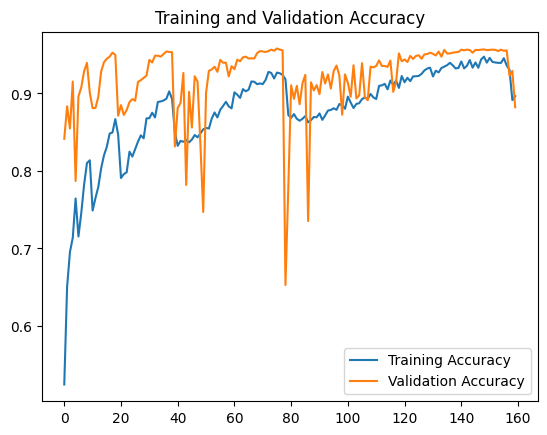

In [10]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs_range = range(epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

## Test Time Augmentation

In [11]:
test_size = 3347
class_num = 11

In [12]:
model = keras.models.load_model(model_dir+'Best-{}.h5'.format(model.name))

#predicting augmented test set
aug_pred = np.zeros(shape=(test_size, class_num))
aug_epochs = 10

for aug_epoch in range(aug_epochs):
    print('---Predicting run {}'.format(aug_epoch))
    test_set_aug = test_set.map(lambda x: aug_fn(x))
    aug_pred += model.predict(test_set_aug)

aug_pred = aug_pred/aug_epochs
aug_pred_class = np.argmax(aug_pred, axis=1)
print(aug_pred_class)

---Predicting run 0
419/419 [==============================] - 34s 76ms/step
---Predicting run 1
419/419 [==============================] - 31s 74ms/step
---Predicting run 2
419/419 [==============================] - 31s 74ms/step
---Predicting run 3
419/419 [==============================] - 31s 74ms/step
---Predicting run 4
419/419 [==============================] - 31s 74ms/step
---Predicting run 5
419/419 [==============================] - 31s 74ms/step
---Predicting run 6
419/419 [==============================] - 32s 75ms/step
---Predicting run 7
419/419 [==============================] - 32s 76ms/step
---Predicting run 8
419/419 [==============================] - 31s 75ms/step
---Predicting run 9
419/419 [==============================] - 31s 74ms/step
[2 9 0 ... 0 2 4]


In [13]:
#predicting orignial test set
pred = model.predict(test_set)
pred_class = np.argmax(pred, axis=1)
print(pred_class)

419/419 [==============================] - 24s 56ms/step
[2 9 0 ... 0 2 4]


In [14]:
#weighting
pred_all = aug_pred*0.5+pred*0.5
pred_all_class = np.argmax(pred_all, axis=1)
print(pred_all_class)

[2 9 0 ... 0 2 4]


In [15]:
df = pd.DataFrame()
for id, category in enumerate(pred_all_class):
    df = df.append({'Id': f'{id+1:04}', 'Category': str(category)}, ignore_index=True)
df.to_csv('submission-{}-TTA.csv'.format(model.name), index=False)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense (Dense)               (None, 11)                14091     
                                                                 
Total params: 20,345,451
Trainable params: 20,191,579
Non-trainable params: 153,872
_________________________________________________________________


## Ensemble

In [22]:
name_list = ['efficientnetv2s', 'resnext50d', 'xception']
pred_all = np.zeros(shape=(test_size, class_num))
aug_epochs = 10

for name in name_list:
    model = keras.models.load_model(model_dir+'Best-{}.h5'.format(name))
    aug_pred = np.zeros(shape=(test_size, class_num))
    for aug_epoch in range(aug_epochs):
        print('---Predicting {} run {}'.format(name, aug_epoch))
        test_set_aug = test_set.map(lambda x: aug_fn(x))
        aug_pred += model.predict(test_set_aug)/aug_epochs
    pred = model.predict(test_set)
    pred_all += (aug_pred*0.5+pred*0.5)/len(name_list)

---Predicting efficientnetv2s run 0
419/419 [==============================] - 34s 76ms/step
---Predicting efficientnetv2s run 1
419/419 [==============================] - 31s 74ms/step
---Predicting efficientnetv2s run 2
419/419 [==============================] - 32s 76ms/step
---Predicting efficientnetv2s run 3
419/419 [==============================] - 31s 75ms/step
---Predicting efficientnetv2s run 4
419/419 [==============================] - 33s 78ms/step
---Predicting efficientnetv2s run 5
419/419 [==============================] - 31s 74ms/step
---Predicting efficientnetv2s run 6
419/419 [==============================] - 32s 75ms/step
---Predicting efficientnetv2s run 7
419/419 [==============================] - 32s 75ms/step
---Predicting efficientnetv2s run 8
419/419 [==============================] - 31s 74ms/step
---Predicting efficientnetv2s run 9
419/419 [==============================] - 24s 56ms/step
---Predicting resnext50d run 0
419/419 [==============================

In [19]:
pred_all_class = np.argmax(pred_all, axis=1)
print(pred_all_class)

[2 9 0 ... 0 2 4]


In [21]:
df = pd.DataFrame()
for id, category in enumerate(pred_all_class):
    df = df.append({'Id': f'{id+1:04}', 'Category': str(category)}, ignore_index=True)
df.to_csv('submission-ensemble.csv', index=False)

## Hyperparameter tuning

In [23]:
from tensorboard.plugins.hparams import api as hp

class HyperparameterCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, hparams):
        super(HyperparameterCallback, self).__init__()
        self.log_dir = log_dir
        self.hparams = hparams
        self.best_accuracy = 0
        self.writer = None
  
    def on_train_begin(self, logs=None):
        self.writer = tf.summary.create_file_writer(self.log_dir)
  
    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_categorical_accuracy')
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
  
    def on_train_end(self, logs=None):
        with self.writer.as_default():
            hp.hparams(self.hparams) #紀錄這次訓練的參數
        tf.summary.scalar(metric, self.best_accuracy, step=0)

In [24]:
#hp_opt = hp.HParam('optimizer', hp.Discrete(['adamw', 'sgdw']))
#hp_wd = hp.HParam('weight_decay', hp.Discrete([1e-1, 1e-2, 1e-3]))
hp_init_lr = hp.HParam('init_lr', hp.Discrete([1e-3, 1e-4, 1e-5]))

log_dir = 'logs/hparams/'
os.makedirs(log_dir, exist_ok=True)

metric = 'Accuracy'
with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams=[hp_init_lr], 
        metrics=[hp.Metric(metric, display_name='Accuracy')]) 

In [25]:
def hparam_train(log_dir, hparams, epochs=90):
    print(hparams[hp_init_lr])
    lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=hparams[hp_init_lr],
                                                                    first_decay_steps=6)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer, 
                  loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
                  metrics=[keras.metrics.CategoricalAccuracy()])

    model_tb = keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    model_mckp = keras.callbacks.ModelCheckpoint(log_dir+'/Best-{}-lr{}.h5'.format(model.name, hparams[hp_init_lr]), 
                                                 monitor='val_categorical_accuracy', 
                                                 save_best_only=True,
                                                 mode='max')
    model_hparam = HyperparameterCallback(log_dir, hparams)

    model.fit(train_set, 
              epochs=epochs, 
              validation_data=valid_set, 
              callbacks=[model_tb, model_hparam]) #model_mckp

In [ ]:
session_id = 1
for init_lr in hp_init_lr.domain.values:
    print('---Running session {}'.format(session_id))
    hparams = {hp_init_lr: init_lr}
    log_dir = 'logs/hparams/'+'run-{}'.format(session_id)
    hparam_train(log_dir, hparams)
    session_id += 1